In [146]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy.stats import sem

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths import rolling_mean

sys.path.append("./")

fld = Path(os.getcwd()).parent
sys.path.append(str(fld))


from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

# cache = Path(r"/Volumes/EGZONA/Egzona/Forceplate/neuropixels")
# cache = Path("/Volumes/EGZONA/Egzona/Forceplate/neuropixels")
cache = Path("/Users/federicoclaudi/Desktop/APA")
tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files]
len(recordings)



18

## Get for each recordings all the time the mouse goes from stationary to moving

In [153]:
tracking, units = load_rec_data(cache, recordings[17])

right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl", cutoff=1500)
left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl", cutoff=1500)

print(f"Number of onsets: {len(right_fl_onsets)} right - {len(left_fl_onsets)} left")

Found 2109 movement candidates
Found 2109 movement candidates
Number of onsets: 14 right - 12 left


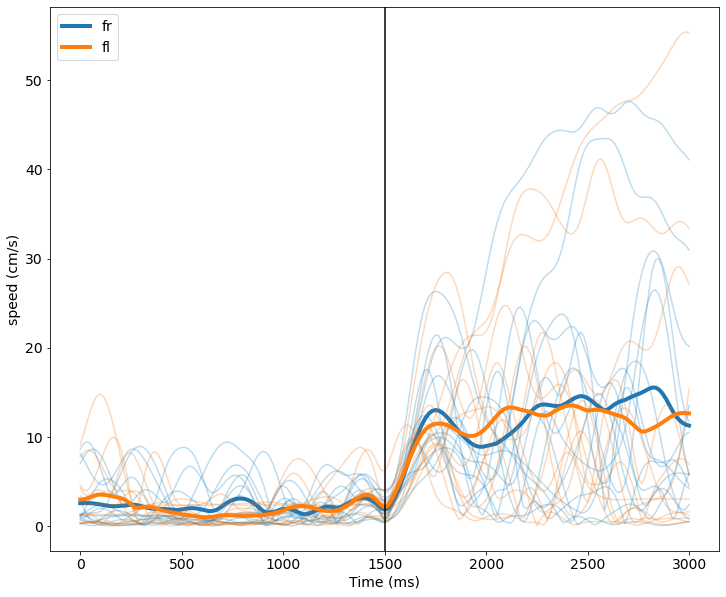

In [154]:
# set font size
plt.rcParams.update({"font.size": 14})

f, ax = plt.subplots(1, 1, figsize=(12, 10))

from analysis.fixtures import dark_colors

for paw, timepoints, v , sign in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), (tracking.right_fl_v, tracking.left_fl_v), (1, -1)):
    traces = []
    for i, frame in enumerate(timepoints):
        trace = v.values[frame-1500:frame+1500]
        traces.append(trace)
        ax.plot(trace, color = dark_colors[paw], alpha=.25)
        # ax.plot(-1 * tracking.left_fl_v.values[frame-1500:frame+1500], color = "red", alpha=.25)
        # ax.plot(-1 * tracking.right_fl_v[frame-1500:frame+1500].values, color = "red", alpha=.25)
    # break
    ax.plot(np.mean(traces, axis=0), label=paw, lw=4)
    # break


ax.legend()
ax.axvline(1500, color="k")
_ = ax.set(xlabel="Time (ms)", ylabel="speed (cm/s)")

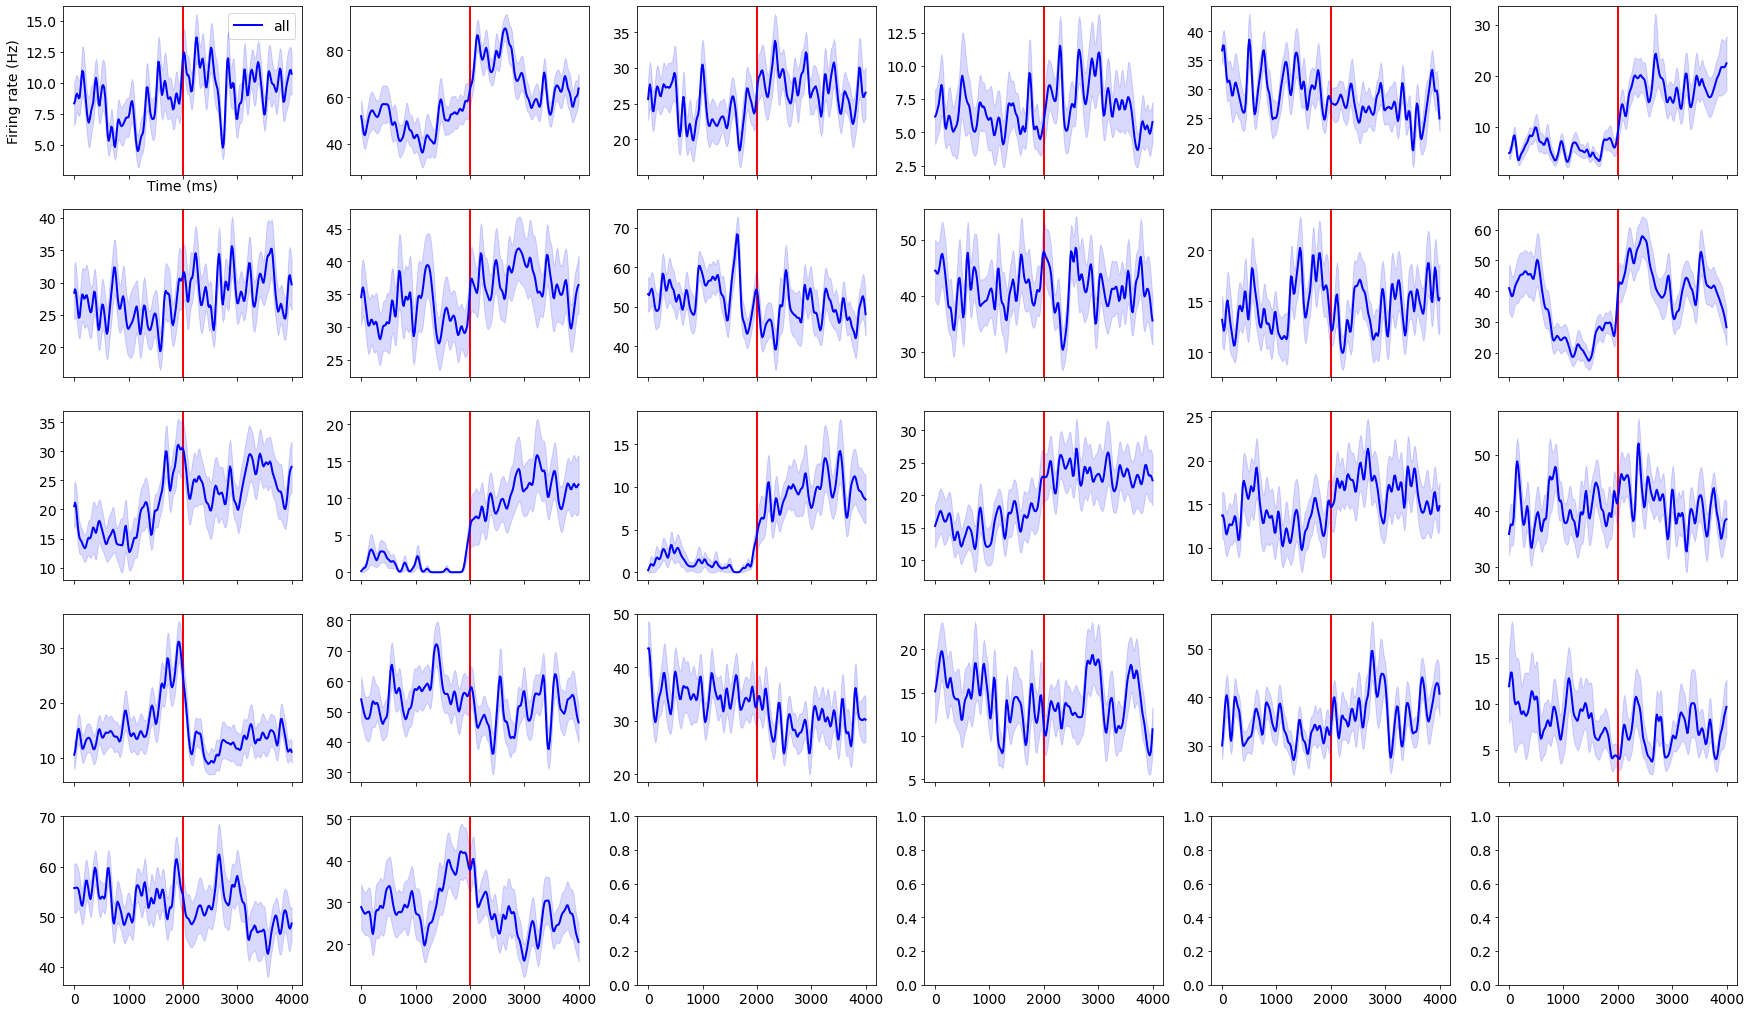

In [155]:
from fcutils.plot.figure import calc_nrows_ncols

figsize = (30, 18)
units_names = units.columns
nrows, ncols = calc_nrows_ncols(len(units_names), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=False)
axes = axes.flatten()

DeltaT = 2000 # time before/after frame
BaselineDuration = 2000 # number of samples going into baseline evaluation


units_traces = {}
for i, (name, ax) in enumerate(zip(units_names, axes)):
    ax.axvline(DeltaT, lw=2, color="r")
    baselines = []
    alltraces = []
    for paw, timepoints, color in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), "rg"):
        traces = []
        for frame in timepoints:
            trace = units[name].values[frame-DeltaT:frame+DeltaT]
            baseline = units[name].values[frame-BaselineDuration-1000:frame-1000]

            if len(trace) < 4000:
                continue
            traces.append(trace)
            baselines.append(baseline)
            # ax.plot(trace, color = dark_colors[paw], alpha=.25) 
            

        alltraces.extend(traces)
        # plot_mean_and_error(np.mean(traces, axis=0), sem(traces, axis=0), ax, lw=2, label=paw if i == 0 else None, color=color, err_alpha=.15)
    
    plot_mean_and_error(
            np.mean(alltraces, axis=0), 
            sem(alltraces, axis=0), 
            ax, lw=2, label="all" if i == 0 else None, color='blue', err_alpha=.15)
    # ax.set(ylim=[np.percentile(alltraces, 10), np.percentile(alltraces, 90)])

    # baselines = np.hstack(baseline)
    # mu = np.mean(baselines)
    # sigma = np.std(baselines)
    # plot_mean_and_error(np.repeat(mu, 2*DeltaT), np.repeat(sigma, 2*DeltaT), ax, lw=2, color="black", err_alpha=.15)
    units_traces[name] = alltraces

axes[0].legend()
_ = axes[0].set(xlabel="Time (ms)", ylabel="Firing rate (Hz)")

In [152]:
# np.vstack([np.vstack(u) for u in units_traces.values()]).shape
